# Heteroskedastic Likelihood and Multi-Latent GP

## Standard (Homoskedastic) Regression
In standard GP Regression, the GP latent function is used to learn the location parameter of a likelihood distribution (usually a Gaussian) as a function of the input $x$, whereas the scale parameter is considered constant. This is a homoskedastic model, which is unable to capture variations of the noise distribution with the input $x$.


## Heteroskedastic Regression
This notebooks shows how to construct a model which uses multiple (2) GP latent functions to learn both the location and the scale of the Gaussian likelihood distribution. It does so by connecting a **Multi-Output Kernel**, which generates multiple GP latent functions, to a **Heteroskedastic Likelihood**, which maps the latent GPs into a single likelihood.

The generative model is described as:

$$ f_1(x) \sim \mathcal{GP}(0, k_1(\cdot, \cdot)) $$
$$ f_2(x) \sim \mathcal{GP}(0, k_2(\cdot, \cdot)) $$
$$ \text{loc}(x) = f_1(x) $$
$$ \text{scale}(x) = \text{transform}(f_2(x)) $$
$$ y_i|f_1, f_2, x_i \sim \mathcal{N}(\text{loc}(x_i),\;\text{scale}^2(x_i))$$

Where the function $\text{transform}$ is used to map the GP $f_2$ to **positive-only values**, which is required as it represent the $\text{scale}$ of a Gaussian likelihood. In this notebook, the $\exp$ function will be used as the $\text{transform}$. An alternative would be the $\text{softplus}$ function.

In [1]:
import numpy as np
import gpflow as gpf
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

# Data Generation
We generate some heteroskedastic data by substituting the random latent functions $f_1$ and $f_2$ of the generative model by deterministic $\sin$ and $\cos$ functions. The input $X$ is built with $N=1001$ uniformly spaced values in the interval $[0, 4\pi]$. The outputs $Y$ are still sampled from a Gaussian likelihood.

$$ x_i \in [0, 4\pi], \quad i = 1,\dots,N $$
$$ f_1(x) = \sin(x) $$
$$ f_2(x) = \cos(x) $$
$$ \text{loc}(x) = f_1(x) $$
$$ \text{scale}(x) = \exp(f_2(x)) $$
$$ y_i|x_i \sim \mathcal{N}(\text{loc}(x_i),\;\text{scale}^2(x_i))$$

In [2]:
N = 1001

np.random.seed(0)
tf.random.set_seed(0)

# Build inputs X
X = np.linspace(0, 4 * np.pi, N)[:, None]  # X must be of shape [N, 1]

# Deterministic functions in place of latent ones
f1 = np.sin
f2 = np.cos

# Use transform = exp to ensure positive-only scale values
transform = np.exp

# Compute loc and scale as functions of input X
loc = f1(X)
variance = transform(f2(X))
scale = variance ** 0.5

# Sample outputs Y from Gaussian Likelihood
Y = np.random.normal(loc, scale)

# Plot Data
Note how the distribution density (shaded area) and the outputs $Y$ are more/less scatered depending on the input $X$.

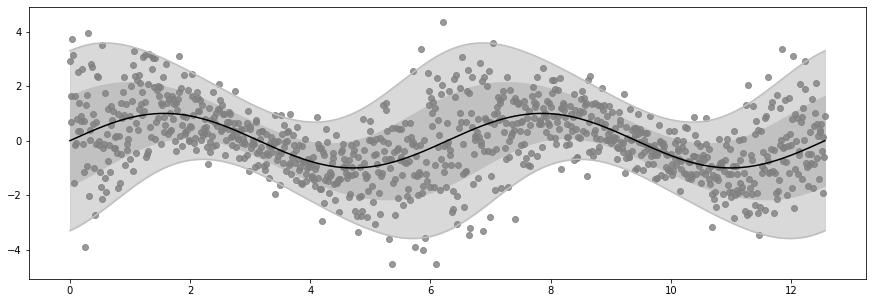

In [3]:
plt.figure(figsize=(15, 5))
for k in (1, 2):
    x = X.squeeze()
    lb = (loc - k * scale).squeeze()
    ub = (loc + k * scale).squeeze()
    plt.fill_between(x, lb, ub, color="silver", alpha=1 - 0.05 * k ** 3)
plt.plot(x, lb, color="silver")
plt.plot(x, ub, color="silver")
plt.plot(X, loc, color="black")
plt.scatter(X, Y, color="gray", alpha=0.8)
plt.show()
plt.close()

# Build Model

## Likelihood
This implements the following part of the generative model:
$$ \text{loc}(x) = f_1(x) $$
$$ \text{scale}(x) = \text{transform}(f_2(x)) $$
$$ y_i|f_1, f_2, x_i \sim \mathcal{N}(\text{loc}(x_i),\;\text{scale}^2(x_i))$$

In [4]:
likelihood = gpf.likelihoods.HeteroskedasticTFPConditional(
    distribution_class=tfp.distributions.Normal,  # Gaussian Likelihood
    transform=tfp.bijectors.Exp(),  # Exponential Transform
)

print(f"Likelihood's expected latent_dim: {likelihood.latent_dim}")

Likelihood's expected latent_dim: 2


## Kernel
This implements the following part of the generative model:
$$ f_1(x) \sim \mathcal{GP}(0, k_1(\cdot, \cdot)) $$
$$ f_2(x) \sim \mathcal{GP}(0, k_2(\cdot, \cdot)) $$
with both kernels being modeled as separated and independent $\text{RBF}$ kernels.

In [5]:
kernel = gpf.kernels.SeparateIndependent(
    [
        gpf.kernels.RBF(),  # This is k1, the kernel of f1
        gpf.kernels.RBF(),  # this is k2, the kernel of f2
    ]
)
# The list contained in gpf.kernels.SeparateIndependent must be the same size of likelihood.latent_dim

# Inducing Points
Since we will use the **SVGP** model to perform inference, we need to implement the inducing variables $U_1$ and $U_2$, both with size $M=20$, which are used to approximate $f_1$ and $f_2$ respectively, and initialize the inducing points positions $Z_1$ and $Z_2$. This gives a total of $2M=40$ inducing variables and inducing points.

The inducing variables and their corresponding inputs will be Separate and Independent, but both $Z_1$ and $Z_2$ will be initialized as $Z$, which are placed as $M=20$ equally spaced points in $[\min(X), \max(X)]$.


In [6]:
M = 20  # Number of inducing variables for each f_i

# Initial inducing points position Z
Z = np.linspace(X.min(), X.max(), M)[:, None]  # Z must be of shape [M, 1]

inducing_variable = gpf.inducing_variables.SeparateIndependentInducingVariables(
    [
        gpf.inducing_variables.InducingPoints(Z),  # This is U1 = f1(Z1)
        gpf.inducing_variables.InducingPoints(Z),  # This is U2 = f2(Z2)
    ]
)
# The list contained in gpf.kernels.SeparateIndependent must be the same size of likelihood.latent_dim

## SVGP Model
Build the **SVGP** model by composing composing the **Kernel**, the **Likelihood** and the **Inducing Variables**.

Note that the model needs to be instructed about the number of latent GPs by passing `num_latent_gps=likelihood.latent_dim`

In [7]:
model = gpf.models.SVGP(
    kernel=kernel,
    likelihood=likelihood,
    inducing_variable=inducing_variable,
    num_latent_gps=likelihood.latent_dim,
)

model

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,1.0
SVGP.inducing_variable.inducing_variable_list[0].Z,Parameter,Identity,,True,"(20, 1)",float64,[[0....
SVGP.inducing_variable.inducing_variable_list[1].Z,Parameter,Identity,,True,"(20, 1)",float64,[[0....
SVGP.q_mu,Parameter,Identity,,True,"(20, 2)",float64,"[[0., 0...."
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(2, 20, 20)",float64,"[[[1., 0., 0...."


# Build Optimizers (NatGrad + Adam)

In [8]:
data = (X, Y)
loss_fn = model.training_loss_closure(data)

gpf.utilities.set_trainable(model.q_mu, False)
gpf.utilities.set_trainable(model.q_sqrt, False)

variational_vars = [(model.q_mu, model.q_sqrt)]
natgrad_opt = gpf.optimizers.NaturalGradient(gamma=0.01)

adam_vars = model.trainable_variables
adam_opt = tf.optimizers.Adam(0.01)

# Run Optimization Loop

Instructions for updating:
Use fn_output_signature instead


Epoch 20 - Loss:  1480.6894


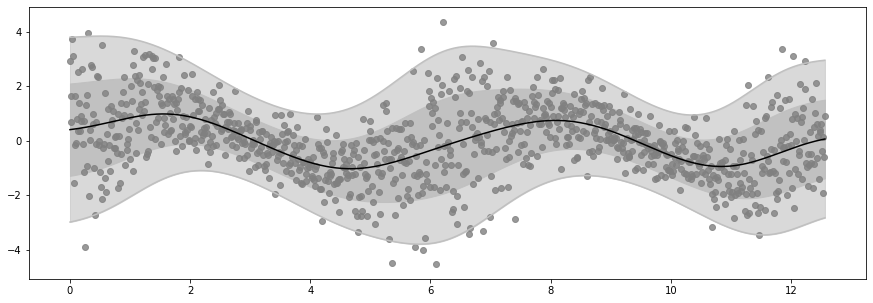

Epoch 40 - Loss:  1453.4229


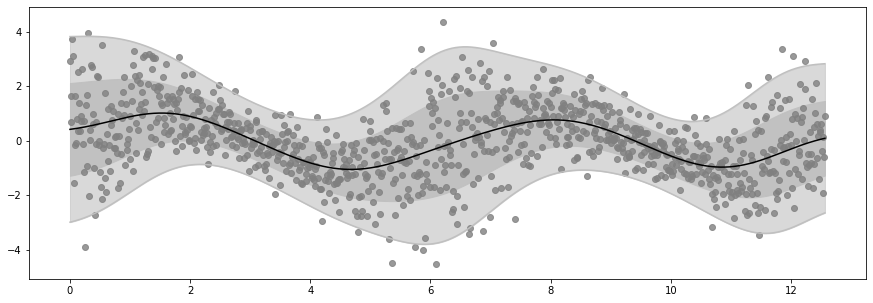

Epoch 60 - Loss:  1445.5631


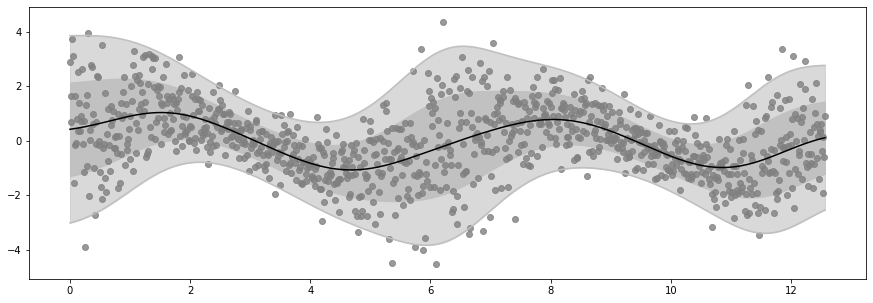

Epoch 80 - Loss:  1442.3754


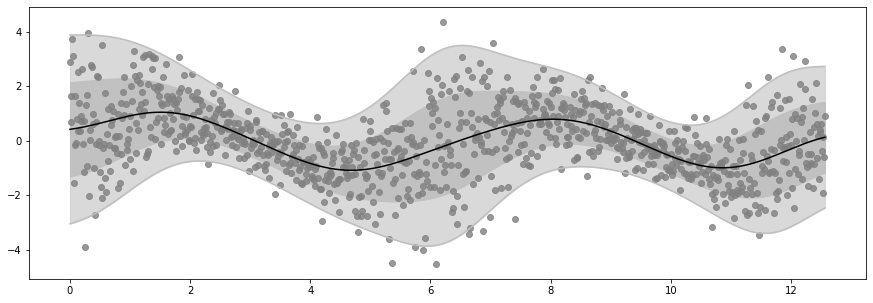

Epoch 100 - Loss:  1440.8359


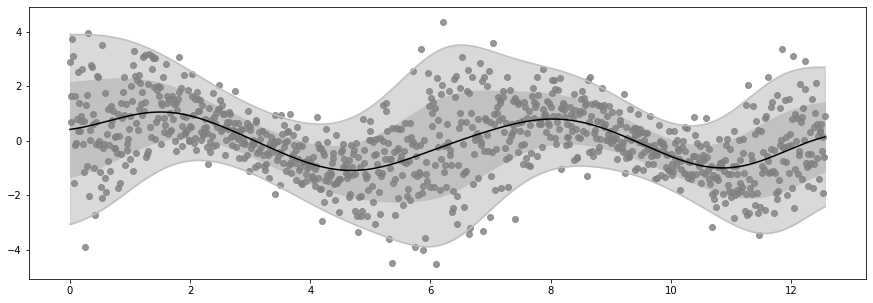

In [9]:
epochs = 100
log_freq = 20

for epoch in range(epochs + 1):
    natgrad_opt.minimize(loss_fn, variational_vars)
    adam_opt.minimize(loss_fn, adam_vars)

    # For every 'log_freq' epochs, print the epoch and plot the predictions against the data
    if epoch % log_freq == 0 and epoch > 0:
        print(f"Epoch {epoch} - Loss: {loss_fn().numpy() : .4f}")
        Ymean, Yvar = model.predict_y(X)
        Ymean = Ymean.numpy().squeeze()
        Ystd = tf.sqrt(Yvar).numpy().squeeze()
        plt.figure(figsize=(15, 5))
        for k in (1, 2):
            x = X.squeeze()
            lb = (Ymean - k * Ystd).squeeze()
            ub = (Ymean + k * Ystd).squeeze()
            plt.fill_between(x, lb, ub, color="silver", alpha=1 - 0.05 * k ** 3)
        plt.plot(x, lb, color="silver")
        plt.plot(x, ub, color="silver")
        plt.plot(X, Ymean, color="black")
        plt.scatter(X, Y, color="gray", alpha=0.8)
        plt.show()
        plt.close()